In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns


In [2]:
file_path = "Incendios.xlsx"
df = pd.read_excel(file_path)

In [3]:
variables_numericas = [
    "Temperatura °C",
    "Humedad %",
    "Velocidad viento Km/hra",
    "Pendiente %",
    "Pino 0 a 10",
    "Pino 11 a 17",
    "Pino 18 o más",
    "Eucalipto",
    "Matorral",
    "Pastizal",
    "Agrícola",
    "Superficie total Has",
]

df_clean = df[variables_numericas].copy()
df_clean = df_clean.replace('%', '', regex=True)
df_clean = df_clean.apply(pd.to_numeric, errors='coerce').dropna()


In [4]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_clean)

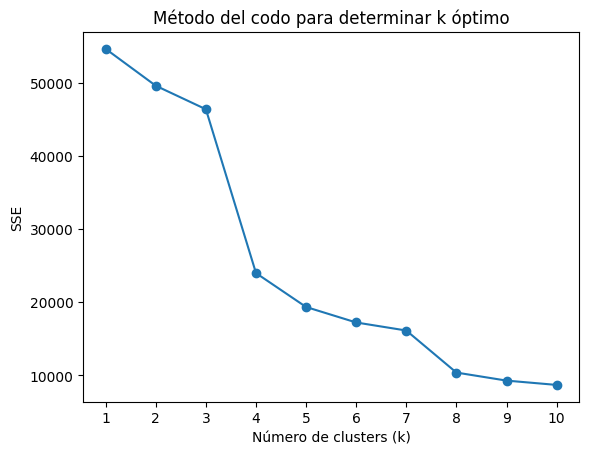

In [5]:

 
# ============================
# MÉTODO DEL CODO
# ============================
sse = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    sse.append(kmeans.inertia_)

plt.figure()
plt.plot(k_values, sse, marker='o')
plt.xticks(k_values)
plt.xlabel("Número de clusters (k)")
plt.ylabel("SSE")
plt.title("Método del codo para determinar k óptimo")
plt.show()

# ============================
# K-MEANS FINAL (k = 3)
# ============================
k_optimo = 3  # ajustar si el codo sugiere otro valor
kmeans_final = KMeans(n_clusters=k_optimo, random_state=42)
kmeans_final.fit(scaled_data)
clusters = kmeans_final.predict(scaled_data)

df_clean["cluster"] = clusters
 

In [6]:

# ============================
# RESUMEN POR CLUSTER
# ============================
resumen_clusters = df_clean.groupby("cluster").mean()
print("Resumen por cluster:")
print(resumen_clusters)


Resumen por cluster:
         Temperatura °C  Humedad %  Velocidad viento Km/hra  Pendiente %  \
cluster                                                                    
0             20.353570  55.795015                 5.726661     4.474420   
1             29.026628  33.972857                 5.659202     2.307556   
2             25.662824  40.752000                 5.674588    60.797647   

         Pino 0 a 10  Pino 11 a 17  Pino 18 o más  Eucalipto    Matorral  \
cluster                                                                    
0           0.475881      0.031461       0.132147   0.114291    0.427698   
1           0.449120      0.265568       3.130417   0.454316    2.960422   
2         135.810847     17.792139     242.668682  34.731506  100.320021   

          Pastizal   Agrícola  Superficie total Has  
cluster                                              
0         0.794661   0.024119              2.439511  
1         2.394393   0.238368             10.792986  
2

In [7]:
# ============================
# SILHOUETTE SCORE
# ============================
sil_score = silhouette_score(scaled_data, clusters)
print("\nSilhouette score:", sil_score)


Silhouette score: 0.32505598352230963


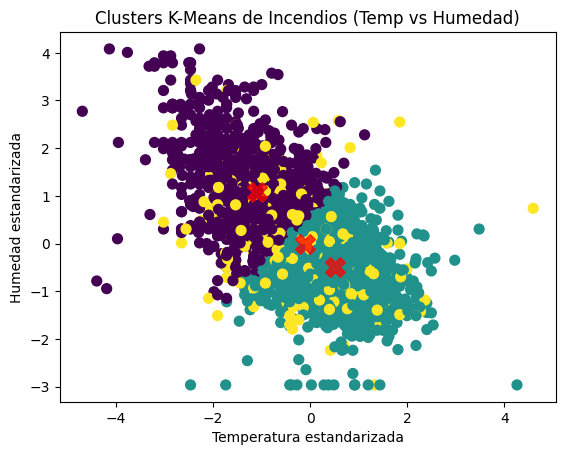

In [8]:
 
# ============================
# GRÁFICO 2D PRINCIPAL (Temp vs Humedad)
# ============================
plt.figure()
plt.scatter(
    scaled_data[:, 0],  # Temperatura
    scaled_data[:, 1],  # Humedad
    c=clusters,
    cmap='viridis',
    s=50
)

centers = kmeans_final.cluster_centers_
plt.scatter(
    centers[:, 0],
    centers[:, 1],
    c='red',
    s=200,
    alpha=0.75,
    marker='X'
)

plt.title("Clusters K-Means de Incendios (Temp vs Humedad)")
plt.xlabel("Temperatura estandarizada")
plt.ylabel("Humedad estandarizada")
plt.show()


In [9]:
  
# ============================
# GUARDAR DATASET CON CLUSTER
# ============================
df_output = df.loc[df_clean.index].copy()
df_output["cluster"] = clusters
df_output.to_excel("incendios_clusterizados.xlsx", index=False)

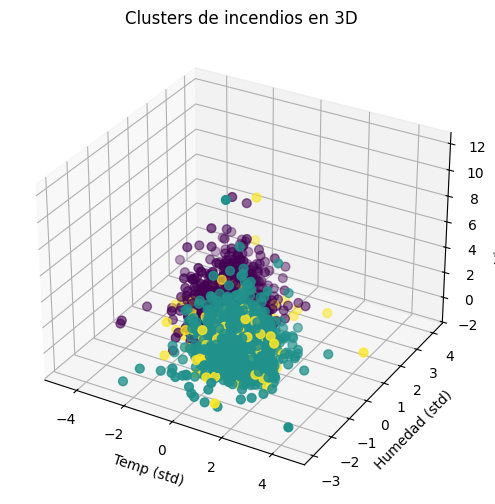

In [11]:
 
# ============================
# GRÁFICO 3D (Temp, Humedad, Viento)
# ============================
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    scaled_data[:, 0],  # Temp
    scaled_data[:, 1],  # Humedad
    scaled_data[:, 2],  # Viento
    c=clusters,
    cmap='viridis',
    s=40
)

ax.set_xlabel("Temp (std)")
ax.set_ylabel("Humedad (std)")
ax.set_zlabel("Viento (std)")
plt.title("Clusters de incendios en 3D")
plt.show()

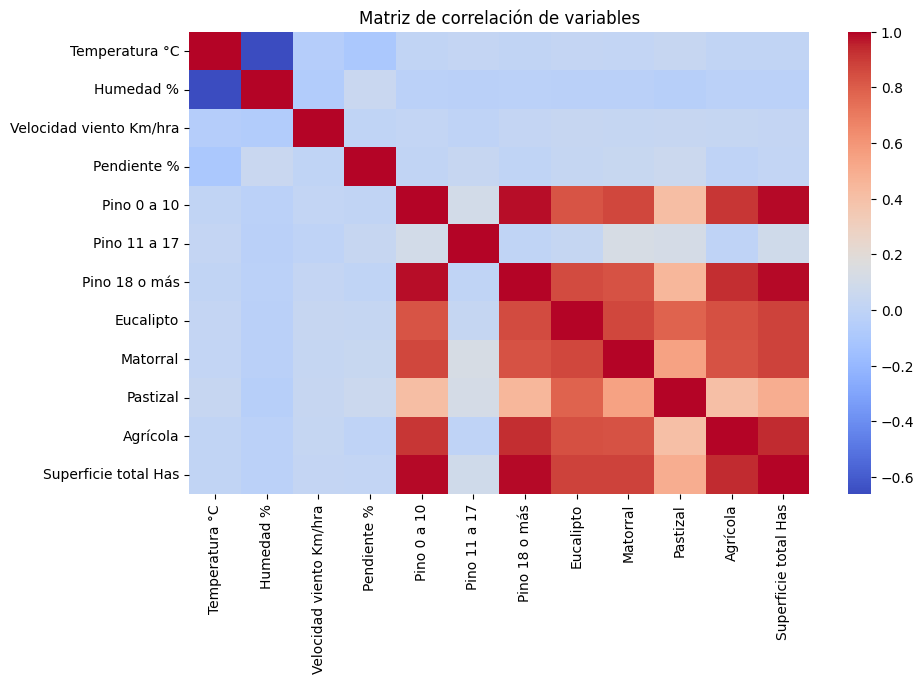

In [12]:
# ============================
# MATRIZ DE CORRELACIÓN
# ============================
plt.figure(figsize=(10, 6))
sns.heatmap(df_clean.drop(columns="cluster").corr(), annot=False, cmap="coolwarm")
plt.title("Matriz de correlación de variables")
plt.show()

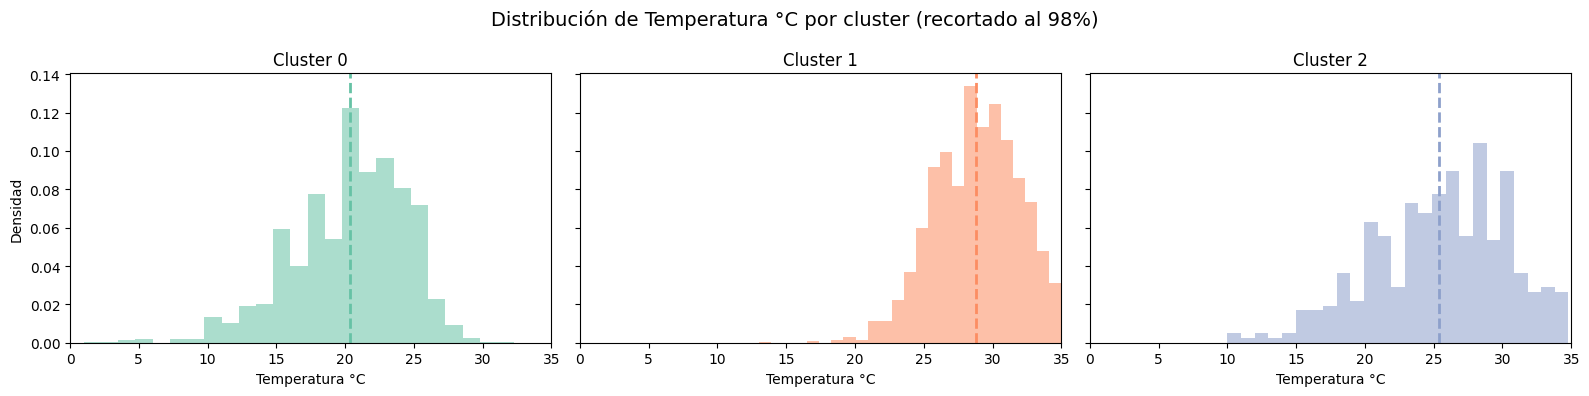

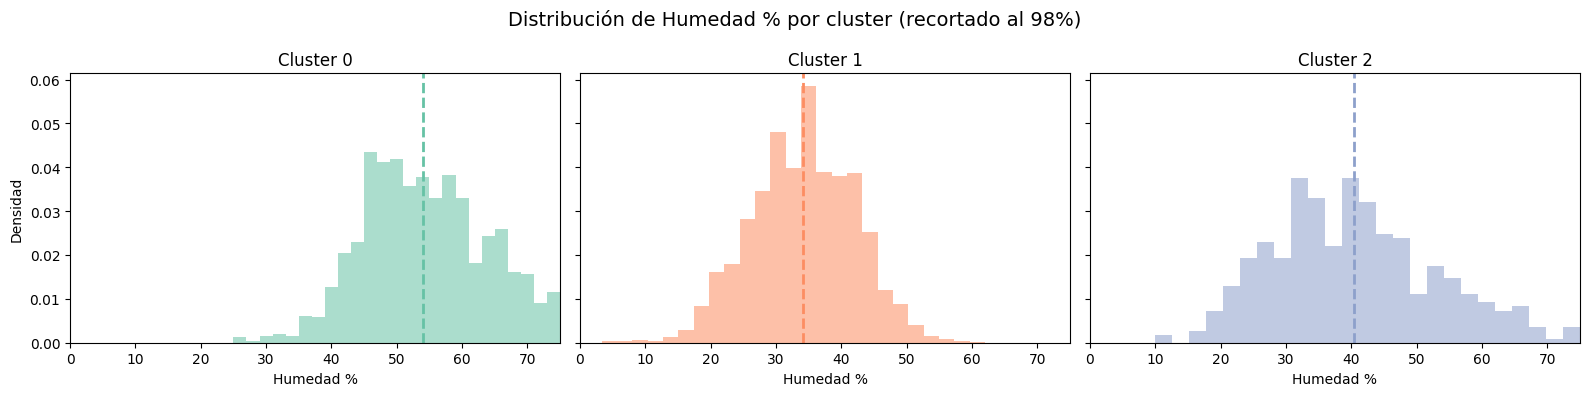

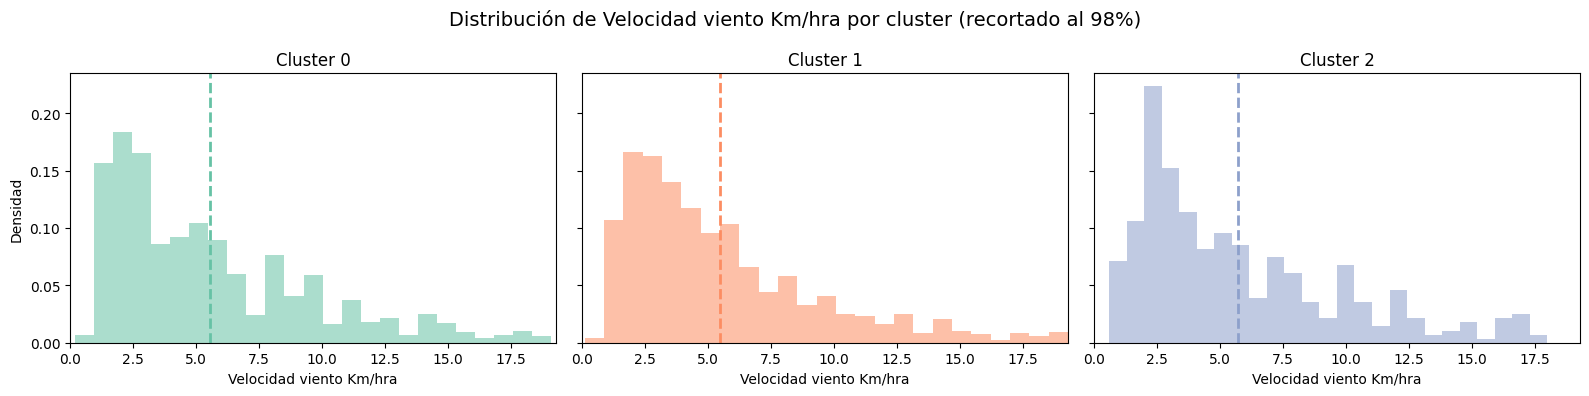

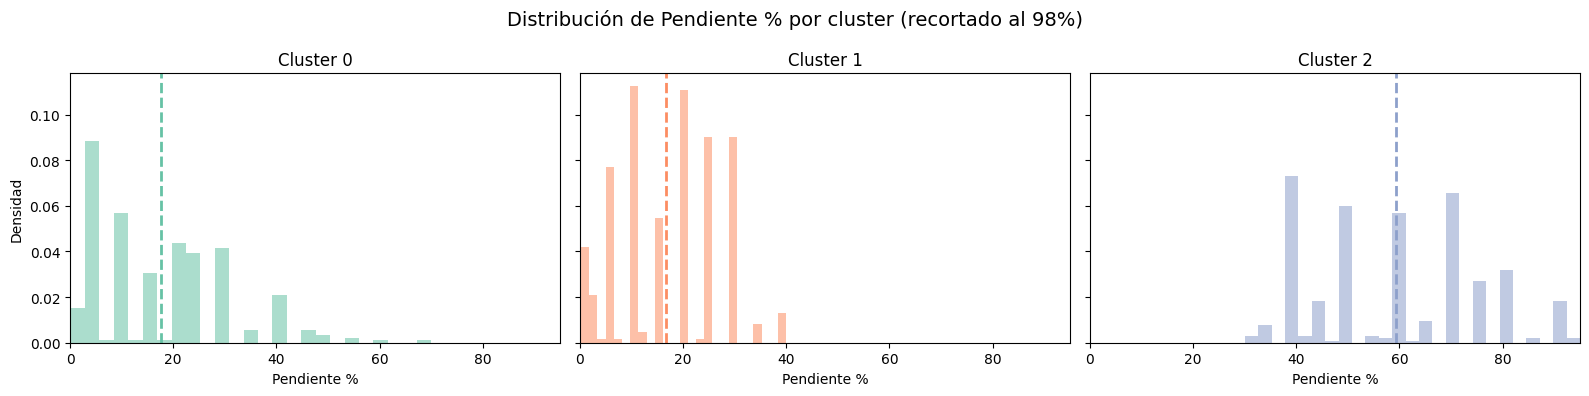

In [18]:
# ============================
# HISTOGRAMAS POR CLUSTER (subplots claros por variable)
# ============================

variables_relevantes = [
    "Temperatura °C",
    "Humedad %",
    "Velocidad viento Km/hra",
    "Pendiente %",
]

clusters_unique = sorted(df_clean["cluster"].unique())
n_clusters = len(clusters_unique)
palette = sns.color_palette("Set2", n_clusters)

for col in variables_relevantes:

    # filtrar valores mayores a 0 para visualizar mejor la distribución
    data_col = df_clean[df_clean[col] > 0].copy()
    if data_col.empty:
        continue

    # recorte del percentil 98
    upper = data_col[col].quantile(0.98)

    # crear subplots (uno por cluster)
    fig, axes = plt.subplots(
        1, n_clusters,
        figsize=(16, 4),
        sharex=True,
        sharey=True
    )

    for i, cl in enumerate(clusters_unique):

        subset = data_col[(data_col["cluster"] == cl) & (data_col[col] <= upper)]
        mean_val = subset[col].mean()

        sns.histplot(
            subset[col],
            bins=25,
            stat="density",
            color=palette[i],
            alpha=0.55,
            edgecolor="none",
            ax=axes[i],
        )

        # línea vertical de la media
        axes[i].axvline(mean_val, color=palette[i], linestyle="--", linewidth=2)
        axes[i].set_title(f"Cluster {cl}")
        axes[i].set_xlim(0, upper)
        axes[i].set_xlabel(col)

        if i == 0:
            axes[i].set_ylabel("Densidad")

    fig.suptitle(f"Distribución de {col} por cluster (recortado al 98%)", fontsize=14)
    plt.tight_layout()
    plt.show()


In [14]:
 
# ============================
# "IMPORTANCIA" APROXIMADA DE VARIABLES
# (promedio de |centroide| por dimensión)
# ============================
centroides = kmeans_final.cluster_centers_
importancias = np.abs(centroides).mean(axis=0)

print("\nImportancia aproximada por variable (mayor = más influyente en los clusters):")
for var, imp in sorted(zip(variables_numericas, importancias), key=lambda x: x[1], reverse=True):
    print(f"{var}: {imp:.3f}")


Importancia aproximada por variable (mayor = más influyente en los clusters):
Pendiente %: 1.076
Temperatura °C: 0.572
Humedad %: 0.530
Matorral: 0.136
Eucalipto: 0.130
Pastizal: 0.121
Superficie total Has: 0.098
Agrícola: 0.094
Pino 11 a 17: 0.084
Pino 0 a 10: 0.083
Pino 18 o más: 0.079
Velocidad viento Km/hra: 0.005


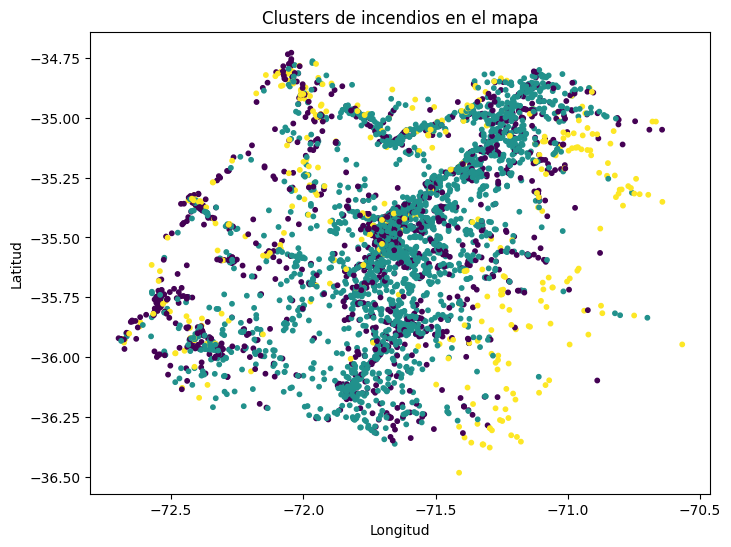

In [ ]:
# ============================
# MAPA SIMPLE (SI HAY LAT/LON DECIMAL)
# ============================
if "Lat Decimal" in df.columns and "Lon Decimal" in df.columns:
    coords = df.loc[df_clean.index, ["Lat Decimal", "Lon Decimal"]].copy()
    coords["cluster"] = clusters

    plt.figure(figsize=(8, 6))
    plt.scatter(coords["Lon Decimal"], coords["Lat Decimal"], c=coords["cluster"], cmap='viridis', s=10)
    plt.title("Clusters de incendios en el mapa")
    plt.xlabel("Longitud")
    plt.ylabel("Latitud")
    plt.show()
